In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA
from pyspark import SparkContext, SparkConf
from sklearn.ensemble import RandomForestClassifier
import sys

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

/home/ttwist/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/ttwist/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [5]:
# Set recursion limit (use with caution)
sys.setrecursionlimit(10000)

# Spark setup
conf = SparkConf().setAppName("Optimized_SSA").setMaster("local[*]")

In [6]:
# Select fraud detection dataset
df = pd.read_csv(path + "/creditcard.csv")
print(df.shape)
# df = df.head(10000)
X = df.drop(['Class'],axis = 1)
y = df['Class']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X.shape

(284807, 31)


(284807, 30)

In [1]:
# Seclect breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X.shape

NameError: name 'load_breast_cancer' is not defined

In [7]:
population_size = 10
max_iter = 100
c1_initial = 2

# Fitness function for SSA (using SVM )
def fitness_function(selected_features, X, y, model=SVC(kernel='linear')):
    selected_indices = [i for i, is_selected in enumerate(selected_features) if is_selected]
    if len(selected_indices) == 0:
        return 1.0  # High penalty if no features are selected
    select = int(X.shape[0])
    X_selected = X[: select , selected_indices]
    y_selected = y[: select ]
    # 5-fold cross-validation accuracy
    accuracy = cross_val_score(model, X_selected, y_selected).mean()
    return 1 - accuracy  # We minimize this (maximize accuracy)

# Salp Swarm Algorithm for feature selection
def salp_swarm_algorithm(X, y, model=SVC(kernel='linear')):
    dim = X.shape[1]
    salp_positions = np.random.randint(2, size=(population_size, dim))
    best_salp_position = None
    best_salp_fitness = float('inf')

    print("Initial Salp Position : \n",salp_positions)

    for iteration in range(max_iter):
        c1 = c1_initial * np.exp(-4 * (iteration / max_iter) ** 2)  # Calculate c1
        
        for i in range(population_size):
            fitness = fitness_function(salp_positions[i], X, y, model)
            if fitness < best_salp_fitness:
                best_salp_fitness = fitness
                best_salp_position = salp_positions[i].copy()

        for i in range(population_size):
            # THis updates the leader salps position
            if i == 0:
                salp_positions[i] = np.where(
                    np.random.rand(dim) < c1,
                    best_salp_position,
                    salp_positions[i]
                )
            # This updates the followers positions
            else:
                salp_positions[i] = (salp_positions[i] + salp_positions[i - 1]) / 2
                salp_positions[i] = np.where(salp_positions[i] >= 0.5, 1, 0)
        # print(f"Iteration {iteration + 1}/{max_iter}, Best Fitness: {1 - best_salp_fitness}")
    print("Final Salp Position : \n",salp_positions)
    print("Best Salp Position : ",best_salp_position)
    print("Best Salp Fitness : ",best_salp_fitness)
    return best_salp_position, 1 - best_salp_fitness

In [1]:
population_size = 10
max_iter = 10
c1_initial = 2

# Fitness function for SSA (using SVM )
def fitness_function_parallel(selected_features,X,y):
    selected_indices = [i for i, is_selected in enumerate(selected_features) if is_selected]
    if len(selected_indices) == 0:
        return 1.0  # Penalty if no features are selected
    X_selected = X[:, selected_indices]
    accuracy = cross_val_score(LogisticRegression(max_iter=1000), X_selected, y, cv=3).mean()
    return 1 - accuracy

# Salp Swarm Algorithm for feature selection
def salp_swarm_algorithm_parallel(X,y):
    sc = SparkContext.getOrCreate(conf=conf)
    bc_X = sc.broadcast(X)
    bc_y = sc.broadcast(y)
    X = bc_X.value
    y = bc_y.value
    # Initialize population
    initial_population = np.random.randint(2, size=(population_size, X.shape[1])).tolist()
    population_rdd = sc.parallelize(initial_population).cache()

    best_salp_position, best_salp_fitness = None, float('inf')
    for iteration in range(max_iter):
        c1 = c1_initial * np.exp(-4 * (iteration / max_iter) ** 2)
    
        # Evaluate fitness in parallel
        fitness_rdd = population_rdd.mapPartitions(lambda iter: [fitness_function_parallel(salp,X,y) for salp in iter])
        fitness_values = fitness_rdd.collect()
    
        min_fitness = min(fitness_values)
        best_index = fitness_values.index(min_fitness)
        best_salp_position = population_rdd.collect()[best_index]
    
        # Broadcast best position
        bc_best_salp_position = sc.broadcast(best_salp_position)
    
        # Update positions
        def update_position(salp, idx):
            salp = np.array(salp)
            if idx == 0:
                return np.where(np.random.rand(X.shape[1]) < c1, bc_best_salp_position.value, salp)
            else:
                prev_salp = np.array(bc_best_salp_position.value)
                return np.where((salp + prev_salp) / 2 >= 0.5, 1, 0)
    
        population_rdd = population_rdd.zipWithIndex().map(lambda x: update_position(x[0], x[1]))
        bc_best_salp_position.unpersist()

        if (iteration + 1) % 10 == 0:
            print(f"Iteration {iteration + 1}/{max_iter}, Best Fitness: {1 - min_fitness}")
    print("Final Salp Position : \n",population_rdd)
    print("Best Salp Position : ",best_salp_position)
    print("Best Salp Fitness : ",1 - min_fitness)
    sc.stop()
    return best_salp_position, 1 - best_salp_fitness

In [9]:
# Cross-validation with the selected features
def evaluate_model_with_selected_features(X, y, selected_features, model=SVC(kernel='linear'), cv=5):
    selected_indices = [i for i, is_selected in enumerate(selected_features) if is_selected]
    X_selected = X[:, selected_indices]
    scores = cross_val_score(model, X_selected, y, cv=cv)
    return scores.mean(), scores.std(),scores

In [9]:
best_features, best_accuracy = salp_swarm_algorithm(X, y, model=SVC(kernel='linear'))
print("SSA :")
print("Selected Features Index:", [i for i, x in enumerate(best_features) if x])
print("Best Accuracy (SVM) During Selection:", best_accuracy)

mean_accuracy, std_dev,ssa_hist = evaluate_model_with_selected_features(X, y, best_features, model=RandomForestClassifier(), cv=5)
print("Cross-validation Results with Selected Features our selected featurees :")
print(f"Mean Accuracy: {mean_accuracy}, Standard Deviation: {std_dev}")

Initial Salp Position : 
 [[0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0]
 [0 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0]
 [1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1]
 [1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1]
 [0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1]
 [0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0 0]
 [0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0]
 [1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 1]
 [0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0]]
Final Salp Position : 
 [[0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0]
 [0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 

In [ ]:
#Salp Swarm PArallel
best_features, best_accuracy = salp_swarm_algorithm_parallel(X,y)
print("SSA :")
print("Selected Features Index:", [i for i, x in enumerate(best_features) if x])
print("Best Accuracy (SVM) During Selection:", best_accuracy)

mean_accuracy, std_dev,ssa_hist = evaluate_model_with_selected_features(X, y, best_features, model=RandomForestClassifier(), cv=5)
print("Cross-validation Results with Selected Features our selected featurees :")
print(f"Mean Accuracy: {mean_accuracy}, Standard Deviation: {std_dev}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/04 12:45:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/11/04 12:45:13 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Iteration 10/10, Best Fitness: 0.9988834530780025
Final Salp Position : 
 PythonRDD[30] at RDD at PythonRDD.scala:53
Best Salp Position :  [1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0]
Best Salp Fitness :  0.9988834530780025
SSA :
Selected Features Index: [0, 1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27]
Best Accuracy (SVM) During Selection: -inf


24/11/04 12:53:34 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /tmp/spark-9d7f15fc-05ce-4e82-8212-e0e27be3f3b8/pyspark-1e65929f-e10e-447f-be90-a8b0d44a1194. Falling back to Java IO way
java.io.IOException: Failed to delete: /tmp/spark-9d7f15fc-05ce-4e82-8212-e0e27be3f3b8/pyspark-1e65929f-e10e-447f-be90-a8b0d44a1194
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:174)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:109)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:90)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively(SparkFileUtils.scala:121)
	at org.apache.spark.util.SparkFileUtils.deleteRecursively$(SparkFileUtils.scala:120)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1126)
	at org.apache.spark.util.ShutdownHookManager$.$anonfun$new$4(ShutdownHookManager.scala:65)
	at org.apache.spark.util.ShutdownHookManager$.$anonfun

In [18]:
# Using different feature selection techniques for comparison
def calculate_gini_index(X, y):
    gini_indices = []
    for feature in range(X.shape[1]):
        feature_values = X[:, feature]
        unique_values = np.unique(feature_values)
        
        gini_feature = 0.0
        for value in unique_values:
            subset_y = y[feature_values == value]
            prob_positive = np.sum(subset_y == 1) / len(subset_y) if len(subset_y) > 0 else 0
            prob_negative = 1 - prob_positive
            gini_value = 1 - (prob_positive**2 + prob_negative**2)
            gini_feature += (len(subset_y) / len(y)) * gini_value
        gini_indices.append(gini_feature)
    return np.array(gini_indices)

def calculate_information_gain(X, y):
    info_gains = []
    entropy_y = - (np.sum(y == 1) / len(y)) * np.log2(np.sum(y == 1) / len(y)) \
                - (np.sum(y == 0) / len(y)) * np.log2(np.sum(y == 0) / len(y))
    
    for feature in range(X.shape[1]):
        feature_values = X[:, feature]
        unique_values = np.unique(feature_values)
        
        # Calculate conditional entropy for the feature
        conditional_entropy = 0.0
        for value in unique_values:
            subset_y = y[feature_values == value]
            if len(subset_y) == 0:
                continue
            prob_positive = np.sum(subset_y == 1) / len(subset_y)
            prob_negative = 1 - prob_positive
            entropy_value = 0
            if prob_positive > 0:
                entropy_value -= prob_positive * np.log2(prob_positive)
            if prob_negative > 0:
                entropy_value -= prob_negative * np.log2(prob_negative)
            conditional_entropy += (len(subset_y) / len(y)) * entropy_value

        # Information gain is the difference in entropy
        info_gain = entropy_y - conditional_entropy
        info_gains.append(info_gain)
    return np.array(info_gains)

def select_top_features(metric_values, top_n):
    return np.argsort(metric_values)[-top_n:]

def evaluate_model(X, y, selected_features, model, cv=5):
    X_selected = X[:, selected_features]
    scores = cross_val_score(model, X_selected, y, cv=cv)
    return scores.mean(), scores.std()

logistic_model = LogisticRegression(max_iter=1000, solver='liblinear')
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

gini_indices = calculate_gini_index(X, y)
info_gains = calculate_information_gain(X, y)

top_n = 10  # Select with first 10 features
gini_selected_features = select_top_features(gini_indices, top_n)
entropy_selected_features = select_top_features(info_gains, top_n)

pca = PCA(n_components=top_n)
X_pca = pca.fit_transform(X)

mean_accuracy_entropy, std_dev_entropy = evaluate_model(X, y, entropy_selected_features, random_forest_model, cv=5)
print("Information Gain-selected Features:")
print(f"Selected Features: {entropy_selected_features}")
print(f"Mean Accuracy: {mean_accuracy_entropy}, Standard Deviation: {std_dev_entropy}\n")

mean_accuracy_entropy, std_dev_entropy = evaluate_model(X, y, gini_selected_features, random_forest_model, cv=5)
print("Gini selected Features:")
print(f"Selected Features: {gini_selected_features}")
print(f"Mean Accuracy: {mean_accuracy_entropy}, Standard Deviation: {std_dev_entropy}\n")

# Testing using PCA
mean_accuracy_entropy, std_dev_entropy = evaluate_model_full_features(X_pca,y,random_forest_model,cv=5)
print("PCA selected features:")
print(f"Mean Accuracy: {mean_accuracy_entropy}, Standard Deviation: {std_dev_entropy}\n")

Information Gain-selected Features:
Selected Features: [ 2  3 16 26 12 10  6 14 23  7]
Mean Accuracy: 0.9455674584691817, Standard Deviation: 0.02438238404896371

Gini selected Features:
Selected Features: [21  0 17 28  1  9 18  4  8 24]
Mean Accuracy: 0.9419655333022823, Standard Deviation: 0.01984371674915783

PCA selected features:
Mean Accuracy: 0.9507685142058685, Standard Deviation: 0.02126230430167862



In [19]:
#This is for testing model without any feature selection
def evaluate_model_full_features(X, y, model, cv=5):
    scores = cross_val_score(model, X, y, cv=cv)
    return scores.mean(), scores.std()

logistic_model = LogisticRegression(max_iter=1000, solver='liblinear')
mean_accuracy_log, std_dev_log = evaluate_model_full_features(X, y, logistic_model, cv=5)
print("Logistic Regression (Full Feature Set):")
print(f"Mean Accuracy: {mean_accuracy_log}, Standard Deviation: {std_dev_log}\n")

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
mean_accuracy_rf, std_dev_rf = evaluate_model_full_features(X, y, random_forest_model, cv=5)
print("Random Forest (Full Feature Set):")
print(f"Mean Accuracy: {mean_accuracy_rf}, Standard Deviation: {std_dev_rf}\n")

Logistic Regression (Full Feature Set):
Mean Accuracy: 0.9595870206489675, Standard Deviation: 0.006971918072338138

Random Forest (Full Feature Set):
Mean Accuracy: 0.9560937742586555, Standard Deviation: 0.02283883380490945



In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve, train_test_split
import numpy as np


# Learning curve plotting function
def plot_learning_curve(model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1
    )
    
    # Calculate mean and standard deviation for training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.title("Learning Curve for Random Forest Classifier")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Define model and plot learning curve
model = RandomForestClassifier()
X_selected = X[:, best_features]

X_temp = df.head(10000).drop(['Class'],axis = 1)
y_temp = df.head(10000)['Class']
plot_learning_curve(model, X_temp, y_temp, cv=5)


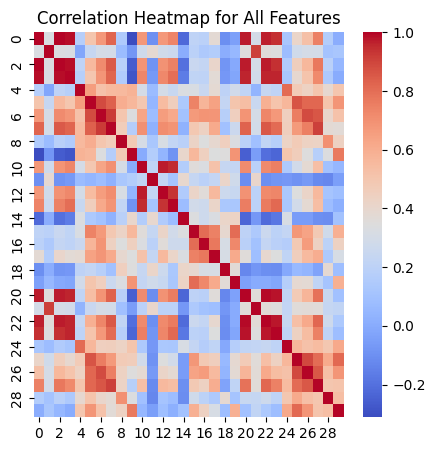

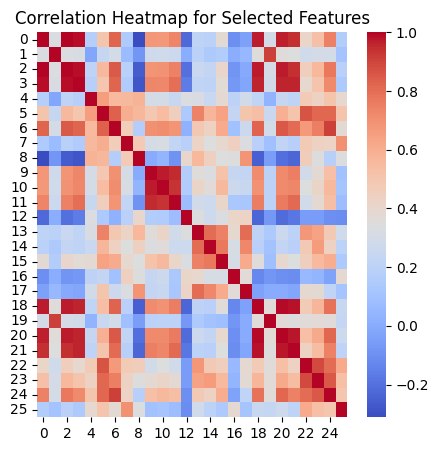

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

selected_features = [i for i, x in enumerate(best_features) if x]

# 1. Heatmap of Correlation for All Features
plt.figure(figsize=(5,5))
corr_matrix = np.corrcoef(X, rowvar=False)
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap for All Features")
plt.show()

# 2. Heatmap of Correlation for Selected Features
X_selected = X[:, selected_features]
plt.figure(figsize=(5, 5))
corr_matrix = np.corrcoef(X_selected, rowvar=False)
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap for Selected Features")
plt.show()
